<a href="https://colab.research.google.com/github/agamduggal/Reinforcement-Learning/blob/main/Improved_path_routing_using_user_feedback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

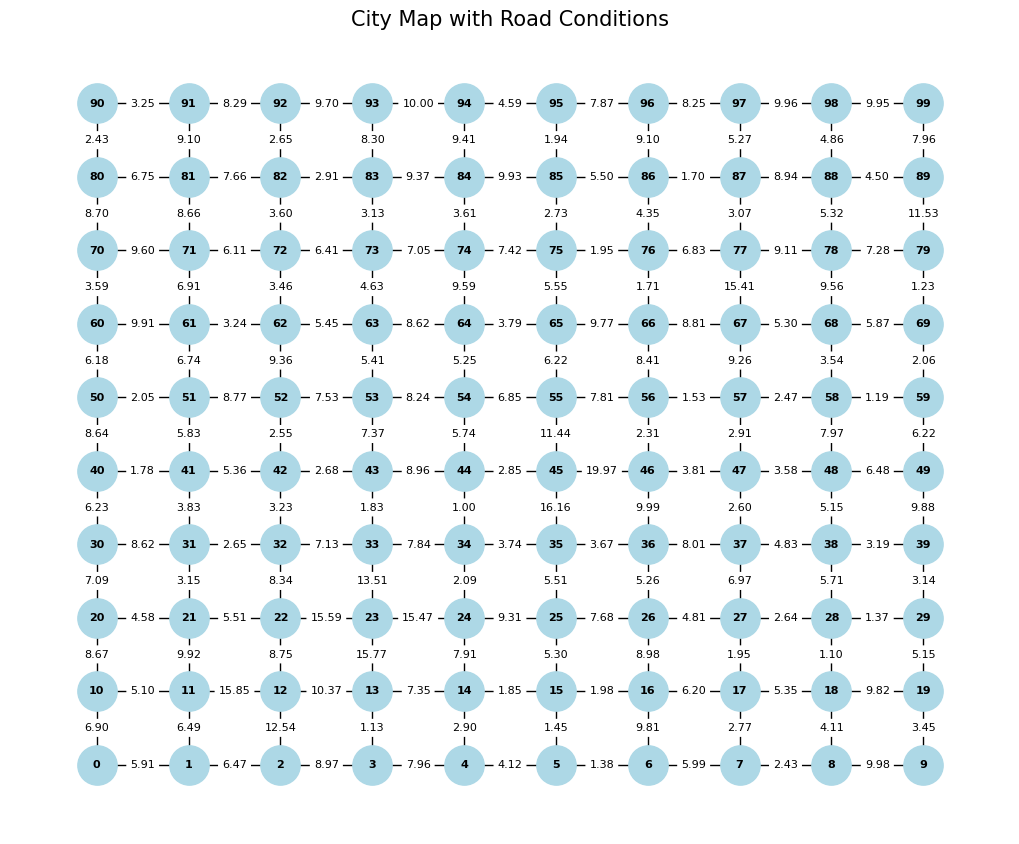

Shortest path (Dijkstra): [0, 1, 2, 3, 13, 14, 15, 16, 17, 27, 37, 47, 57, 58, 59, 69, 79, 89, 99]
Episode 0/1000 completed.
Episode 100/1000 completed.
Episode 200/1000 completed.
Episode 300/1000 completed.
Episode 400/1000 completed.
Episode 500/1000 completed.
Episode 600/1000 completed.
Episode 700/1000 completed.
Episode 800/1000 completed.
Episode 900/1000 completed.


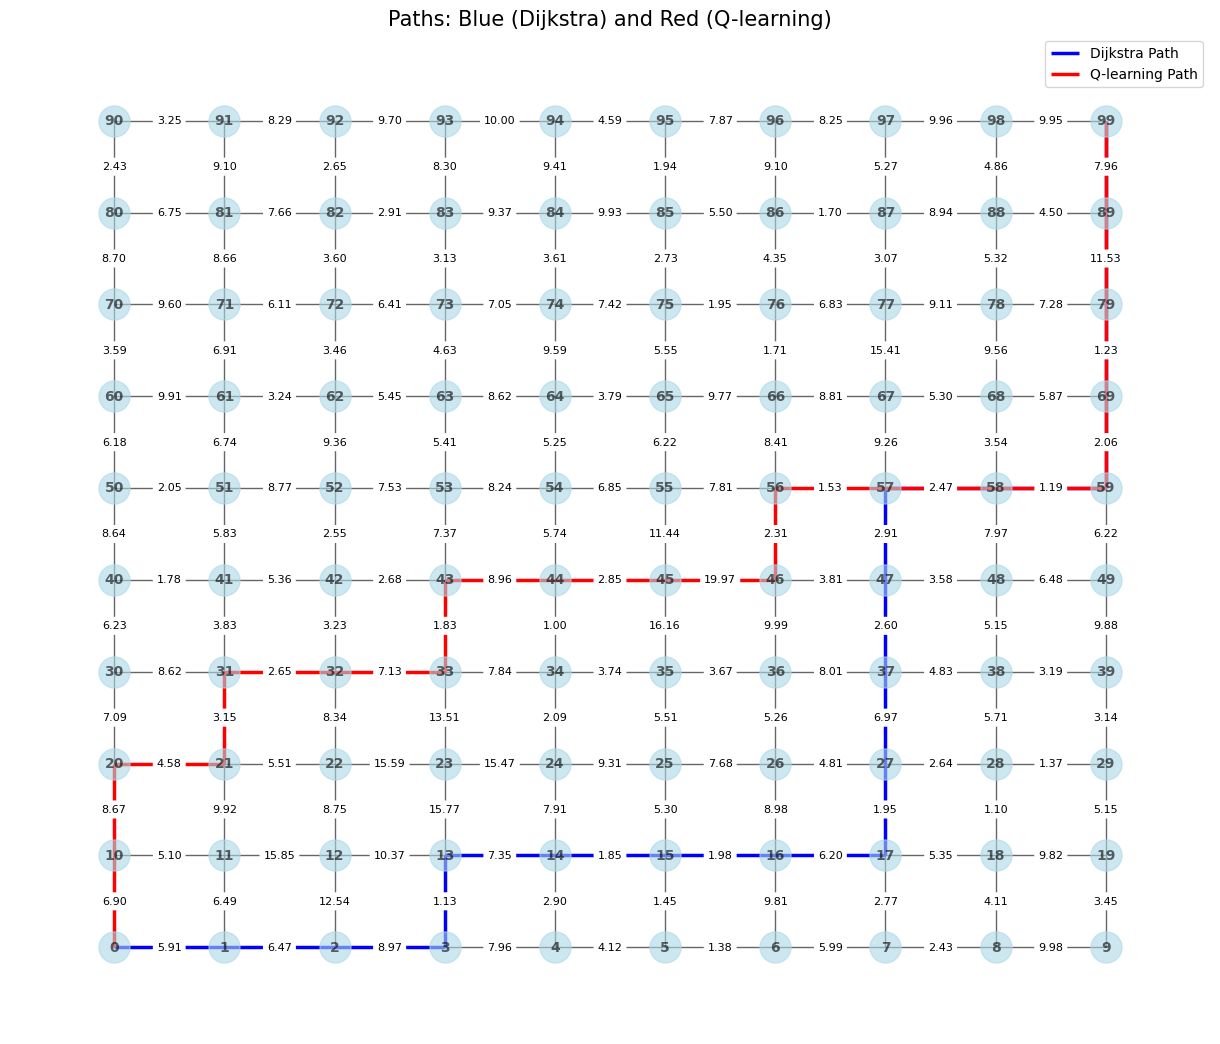

In [19]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Create a sample city map (graph) with a 10x10 grid
size = 10
G = nx.grid_2d_graph(size, size)
G = nx.convert_node_labels_to_integers(G)

# Assign random weights to simulate road conditions (lower weights for safer roads)
for (u, v) in G.edges():
    G.edges[u, v]['weight'] = np.random.uniform(1, 10)  # Simulate road conditions

# Define some disaster zones (nodes with higher weights)
disaster_nodes = [12, 23, 45, 67, 89]
for node in disaster_nodes:
    for neighbor in G.neighbors(node):
        G.edges[node, neighbor]['weight'] *= 2  # Increase weight to simulate disaster

# Visualize the city map with initial conditions
plt.figure(figsize=(10, 8))
pos = {i: (i % size, i // size) for i in range(size * size)}

nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=800, font_size=8, font_weight='bold')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f'{v:.2f}' for k, v in edge_labels.items()}, font_size=8, font_color='black', rotate=False)
plt.title('City Map with Road Conditions', fontsize=15)
plt.show()

# Step 2: Implement Dijkstra's Algorithm
def dijkstra_shortest_path(G, start, end):
    return nx.dijkstra_path(G, start, end, weight='weight')

# Example of finding the shortest path from top-left to bottom-right
start_node = 0  # Top-left corner
end_node = size * size - 1  # Bottom-right corner
shortest_path = dijkstra_shortest_path(G, start_node, end_node)
print(f"Shortest path (Dijkstra): {shortest_path}")

# Q-learning parameters
alpha = 0.1   # Learning rate
gamma = 0.9   # Discount factor
epsilon = 0.1 # Exploration rate
episodes = 1000  # Reduced number of episodes for quicker testing

# Initialize Q-table
Q_table = np.zeros((size * size, 4))  # 4 possible actions (up, down, left, right)

# Actions mapping: 0=up, 1=down, 2=left, 3=right
action_mapping = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)}

# Function to get the next state
def get_next_state(state, action):
    row = state // size
    col = state % size
    move = action_mapping[action]
    next_row, next_col = row + move[0], col + move[1]
    if 0 <= next_row < size and 0 <= next_col < size:
        return next_row * size + next_col
    else:
        return state  # Stay in the same place if the move is out of bounds

# Function to get the reward
def get_reward(state, next_state):
    u, v = state, next_state
    return -G.edges[u, v]['weight'] if G.has_edge(u, v) else -10  # Penalty if there's no edge

# Function to integrate user feedback
def integrate_user_feedback(Q_table, state, next_state, feedback):
    reward = 10 if feedback == 1 else -50  # Positive reward for safe and negative for unsafe
    Q_table[state, action] += alpha * (reward + gamma * np.max(Q_table[next_state]) - Q_table[state, action])

# Q-learning algorithm
start_node = 0  # Top-left corner
end_node = size * size - 1  # Bottom-right corner

for episode in range(episodes):
    state = start_node
    while state != end_node:
        if np.random.uniform(0, 1) < epsilon:
            action = np.random.choice([0, 1, 2, 3])  # Explore
        else:
            action = np.argmax(Q_table[state])  # Exploit learned values

        next_state = get_next_state(state, action)
        reward = get_reward(state, next_state)

        # Q-value update
        Q_table[state, action] += alpha * (reward + gamma * np.max(Q_table[next_state]) - Q_table[state, action])

        # Simulate user feedback (for demonstration purposes)
        user_feedback = np.random.choice([0,1]) # Random feedback for demonstration
        integrate_user_feedback(Q_table, state, next_state, user_feedback)

        state = next_state

    # Debugging output
    if episode % 100 == 0:
        print(f"Episode {episode}/{episodes} completed.")

optimal_path = [start_node]
state = start_node

while state != end_node:
    action = np.argmax(Q_table[state])
    state = get_next_state(state, action)
    optimal_path.append(state)

# Visualization
def plot_paths(G, shortest_path, optimal_path, size):
    plt.figure(figsize=(12, 10))
    pos = {i: (i % size, i // size) for i in range(size * size)}

    # Create a subgraph for visualization
    sample_nodes = set(shortest_path).union(optimal_path)  # Include nodes in both paths
    sample_edges = [(shortest_path[i], shortest_path[i + 1]) for i in range(len(shortest_path) - 1)] + \
                   [(optimal_path[i], optimal_path[i + 1]) for i in range(len(optimal_path) - 1)]

    # Draw the entire graph to get the base layout
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold', alpha=0.6)

    # Draw the Dijkstra path in blue
    nx.draw_networkx_edges(G, pos, edgelist=[(shortest_path[i], shortest_path[i + 1]) for i in range(len(shortest_path) - 1)], edge_color='blue', width=2.5, label='Dijkstra Path')

    # Draw the Q-learning path in red
    nx.draw_networkx_edges(G, pos, edgelist=[(optimal_path[i], optimal_path[i + 1]) for i in range(len(optimal_path) - 1)], edge_color='red', width=2.5, label='Q-learning Path')

    # Draw edge labels
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f'{v:.2f}' for k, v in edge_labels.items()}, font_size=8, font_color='black', rotate=False)

    # Create a legend
    plt.legend()

    plt.title('Paths: Blue (Dijkstra) and Red (Q-learning)', fontsize=15)
    plt.show()

# Plot the paths
plot_paths(G, shortest_path, optimal_path, size)

